In [1]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=50 ,  input_height=320, input_width=640  )

In [2]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 640, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 320, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [34]:
import tensorflow_model_optimization as tfmot 
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched

def prune_model():
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Compute end step to finish pruning after 2 epochs.
    batch_size = 8
    epochs = 2
    validation_split = 0.1 # 10% of training set will be used for validation set. 

    num_images = 40000
    end_step = 800


    #'''
    #Defining pruning parameters

    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                   final_sparsity=0.80,
                                                                   begin_step=0,
                                                                   end_step=1000)
    }

    #'''

    model_copy = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    return model_copy


In [35]:
pruned_model = prune_model()

In [ ]:
----

In [5]:
import tensorflow
import tensorflow_model_optimization as tfmot 
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched


In [6]:
def apply_pruning_to_conv2d(layer):
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer,
                                                        pruning_schedule=pruning_sched.ConstantSparsity(0.5, 0))
    return layer

model_for_pruning = tensorflow.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_conv2d,
)

/home/mohan/virtualenv/divamgupta_tf2/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [8]:
model_for_pruning().train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=1
)

ValueError: The first argument to `Layer.call` must always be passed.

In [ ]:
----

In [5]:
model.train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=1
)

Verifying training dataset


100%|██████████| 367/367 [00:13<00:00, 27.90it/s]


Dataset verified! 
512/512 [==============================] - 67s 98ms/step - loss: 0.8643 - accuracy: 0.7507

Epoch 00001: saving model to /tmp/vgg_unet_1.00001


In [ ]:
train_images,
train_annotations,
input_height=None,
input_width=None,
n_classes=None,
verify_dataset=True,
checkpoints_path=None,
epochs=5,
batch_size=2,
validate=False,
val_images=None,
val_annotations=None,
val_batch_size=2
auto_resume_checkpoint=False
load_weights=None
steps_per_epoch=512
val_steps_per_epoch=512
gen_use_multiprocessing=False
ignore_zero_class=False
optimizer_name='adam'
do_augment=False
augmentation_name="aug_all",
callbacks=None
custom_augmentation=None
other_inputs_paths=None
preprocessing=None
read_image_type=1

In [6]:
out = model.predict_segmentation(
    inp="dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/out.png"
)

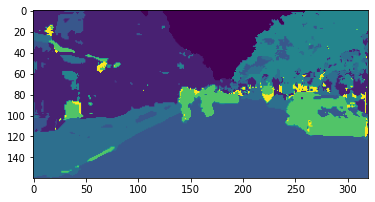

In [7]:
import matplotlib.pyplot as plt
plt.imshow(out)

In [8]:
print(model.evaluate_segmentation( inp_images_dir="dataset1/images_prepped_test/"  , annotations_dir="dataset1/annotations_prepped_test/" ) )

101it [00:11,  9.05it/s]

{'frequency_weighted_IU': 0.6050214532264229, 'mean_IU': 0.07384429412731473, 'class_wise_IU': array([0.93406405, 0.58788693, 0.00452901, 0.8261176 , 0.42162333,
       0.51821346, 0.01932625, 0.00346597, 0.21907917, 0.05031322,
       0.        , 0.1075957 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])}


In [18]:
log_dir = './pruning_logs'
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

In [11]:
model_for_pruning.compile()

In [39]:
pruned_model = prune_model()

In [45]:
train(model_copy,
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=1,
    callbacks = callbacks, n_classes=50
)

AttributeError: 'Functional' object has no attribute 'n_classes'

In [30]:
import json
import os

from keras_segmentation.data_utils.data_loader import image_segmentation_generator, \
    verify_segmentation_dataset
import six
from keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys

In [49]:
train(model_copy,
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=1,
    callbacks = callbacks
)

AttributeError: 'Functional' object has no attribute 'output_height'

In [48]:
def train(model,
          train_images,
          train_annotations,
          input_height=None,
          input_width=None,
          n_classes=50,
          verify_dataset=True,
          checkpoints_path=None,
          epochs=5,
          batch_size=2,
          validate=False,
          val_images=None,
          val_annotations=None,
          val_batch_size=2,
          auto_resume_checkpoint=False,
          load_weights=None,
          steps_per_epoch=512,
          val_steps_per_epoch=512,
          gen_use_multiprocessing=False,
          ignore_zero_class=False,
          optimizer_name='adam',
          do_augment=False,
          augmentation_name="aug_all",
          callbacks=None,
          custom_augmentation=None,
          other_inputs_paths=None,
          preprocessing=None,
          read_image_type=1  # cv2.IMREAD_COLOR = 1 (rgb),
                             # cv2.IMREAD_GRAYSCALE = 0,
                             # cv2.IMREAD_UNCHANGED = -1 (4 channels like RGBA)
         ):
    from keras_segmentation.models.all_models import model_from_name
    # check if user gives model name instead of the model object
    if isinstance(model, six.string_types):
        # create the model from the name
        assert (n_classes is not None), "Please provide the n_classes"
        if (input_height is not None) and (input_width is not None):
            model = model_from_name[model](
                n_classes, input_height=input_height, input_width=input_width)
        else:
            model = model_from_name[model](n_classes)

    n_classes = 50
    input_height = 320
    input_width = 640
    output_height = model.output_height
    output_width = model.output_width

    if validate:
        assert val_images is not None
        assert val_annotations is not None

    if optimizer_name is not None:

        if ignore_zero_class:
            loss_k = masked_categorical_crossentropy
        else:
            loss_k = 'categorical_crossentropy'

        model.compile(loss=loss_k,
                      optimizer=optimizer_name,
                      metrics=['accuracy'])

    if checkpoints_path is not None:
        config_file = checkpoints_path + "_config.json"
        dir_name = os.path.dirname(config_file)

        if ( not os.path.exists(dir_name) )  and len( dir_name ) > 0 :
            os.makedirs(dir_name)

        with open(config_file, "w") as f:
            json.dump({
                "model_class": model.model_name,
                "n_classes": n_classes,
                "input_height": input_height,
                "input_width": input_width,
                "output_height": output_height,
                "output_width": output_width
            }, f)

    if load_weights is not None and len(load_weights) > 0:
        print("Loading weights from ", load_weights)
        model.load_weights(load_weights)

    initial_epoch = 0

    if auto_resume_checkpoint and (checkpoints_path is not None):
        latest_checkpoint = find_latest_checkpoint(checkpoints_path)
        if latest_checkpoint is not None:
            print("Loading the weights from latest checkpoint ",
                  latest_checkpoint)
            model.load_weights(latest_checkpoint)

            initial_epoch = int(latest_checkpoint.split('.')[-1])

    if verify_dataset:
        print("Verifying training dataset")
        verified = verify_segmentation_dataset(train_images,
                                               train_annotations,
                                               n_classes)
        assert verified
        if validate:
            print("Verifying validation dataset")
            verified = verify_segmentation_dataset(val_images,
                                                   val_annotations,
                                                   n_classes)
            assert verified

    train_gen = image_segmentation_generator(
        train_images, train_annotations,  batch_size,  n_classes,
        input_height, input_width, output_height, output_width,
        do_augment=do_augment, augmentation_name=augmentation_name,
        custom_augmentation=custom_augmentation, other_inputs_paths=other_inputs_paths,
        preprocessing=preprocessing, read_image_type=read_image_type)

    if validate:
        val_gen = image_segmentation_generator(
            val_images, val_annotations,  val_batch_size,
            n_classes, input_height, input_width, output_height, output_width,
            other_inputs_paths=other_inputs_paths,
            preprocessing=preprocessing, read_image_type=read_image_type)

    if callbacks is None and (not checkpoints_path is  None) :
        default_callback = ModelCheckpoint(
                filepath=checkpoints_path + ".{epoch:05d}",
                save_weights_only=True,
                verbose=True
            )

        if sys.version_info[0] < 3: # for pyhton 2 
            default_callback = CheckpointsCallback(checkpoints_path)

        callbacks = [
            default_callback
        ]

    if callbacks is None:
        callbacks = []

    if not validate:
        model.fit(train_gen, steps_per_epoch=steps_per_epoch,
                  epochs=epochs, callbacks=callbacks, initial_epoch=initial_epoch)
    else:
        model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch)

In [16]:
import tensorflow
model_copy= tensorflow.keras.models.clone_model(model)